In [1]:
# ======================= Kaggle Notebook: XAI-CNN for Arrhythmia (PyTorch) =======================
# Paper-aligned implementation:
# - Pan–Tompkins QRS detection -> beat segmentation (0.2s before, 0.4s after R) -> 0.6s segments (216 samples @ 360 Hz)
# - Class filtering to { '/', 'A', 'L', 'N', 'R', 'V' }  (6 classes)
# - CNN-only architecture (no LSTM) sized to match the paper's table: lengths 216->167->83->74->37->33->16->Flatten(256)->FC(32)->FC(16)->FC(num_classes)
# - Explainability: Captum GradientSHAP & DeepLift visualizations
# Reference: Explainable AI (XAI) for Arrhythmia detection from electrocardiograms (Aug 26, 2025)  [Beck & John et al.]  (arXiv:2508.17294v1)

# ======================= 0. Install / Imports =======================
!pip -q install wfdb==4.1.2 captum==0.7.0

import os, math, random, json, time, glob
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# ======================= 1. Config =======================
class CFG:
    # Paths (update to your Kaggle dataset mount points)
    MITBIH_DIR = "/kaggle/input/req-data/mit-bih-arrhythmia-database-1.0.0"  # WFDB record folder with .dat/.hea/.atr
    SECOND_DATASET_DIR = "/kaggle/input/second-ecg-dataset"        # Optional (set USE_SECOND_DATASET=False if absent)
    USE_SECOND_DATASET = False  # The paper shows performance drop on combined data (due to heterogeneous leads) :contentReference[oaicite:2]{index=2}

    # ECG sampling & segmentation
    FS = 360                             # MIT-BIH sampling rate
    SEGMENT_SEC = 0.6                    # 600 ms per sample (paper) :contentReference[oaicite:3]{index=3}
    PRE_R_SEC = 0.2                      # 200 ms before R :contentReference[oaicite:4]{index=4}
    POST_R_SEC = 0.4                     # 400 ms after R :contentReference[oaicite:5]{index=5}
    SEGMENT_SAMPLES = int(SEGMENT_SEC * FS)  # 216 samples (paper table input) :contentReference[oaicite:6]{index=6}
    PRE_R = int(PRE_R_SEC * FS)          # 72
    POST_R = int(POST_R_SEC * FS)        # 144

    # Classes retained per paper (after excluding <2000) :contentReference[oaicite:7]{index=7}
    # Mapping MIT-BIH annotation symbols -> class IDs
    KEPT_LABELS = ['/', 'A', 'L', 'N', 'R', 'V']  # Paced, Atrial Premature, LBBB, Normal, RBBB, PVC
    LABEL2ID = {lb:i for i,lb in enumerate(KEPT_LABELS)}
    ID2LABEL = {i:lb for lb,i in LABEL2ID.items()}
    NUM_CLASSES = len(KEPT_LABELS)

    # Train/val split
    VAL_SPLIT = 0.2
    BATCH_SIZE = 256
    EPOCHS = 30
    LR = 1e-3
    WEIGHT_DECAY = 1e-4
    NUM_WORKERS = 2
    DROPOUT = 0.2

    # Pan–Tompkins filtering
    # We'll implement a standard bandpass around QRS and the classic PT steps (derivative, squaring, MWI).
    BP_LO = 5
    BP_HI = 15
    BP_ORDER = 1

    # Training / logging
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    PRINT_EVERY = 50

print(CFG.__dict__)

{'__module__': '__main__', 'MITBIH_DIR': '/kaggle/input/req-data/mit-bih-arrhythmia-database-1.0.0', 'SECOND_DATASET_DIR': '/kaggle/input/second-ecg-dataset', 'USE_SECOND_DATASET': False, 'FS': 360, 'SEGMENT_SEC': 0.6, 'PRE_R_SEC': 0.2, 'POST_R_SEC': 0.4, 'SEGMENT_SAMPLES': 216, 'PRE_R': 72, 'POST_R': 144, 'KEPT_LABELS': ['/', 'A', 'L', 'N', 'R', 'V'], 'LABEL2ID': {'/': 0, 'A': 1, 'L': 2, 'N': 3, 'R': 4, 'V': 5}, 'ID2LABEL': {0: '/', 1: 'A', 2: 'L', 3: 'N', 4: 'R', 5: 'V'}, 'NUM_CLASSES': 6, 'VAL_SPLIT': 0.2, 'BATCH_SIZE': 256, 'EPOCHS': 30, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'NUM_WORKERS': 2, 'DROPOUT': 0.2, 'BP_LO': 5, 'BP_HI': 15, 'BP_ORDER': 1, 'DEVICE': 'cuda', 'PRINT_EVERY': 50, '__dict__': <attribute '__dict__' of 'CFG' objects>, '__weakref__': <attribute '__weakref__' of 'CFG' objects>, '__doc__': None}


In [3]:
import os, glob
print("Files in MITBIH_DIR:", os.listdir(CFG.MITBIH_DIR))
print("Number of .dat files:", len(glob.glob(CFG.MITBIH_DIR + "/*.dat")))
print("Example .dat files:", glob.glob(CFG.MITBIH_DIR + "/*.dat")[:5])



Files in MITBIH_DIR: ['117.atr', '207.xws', '212.xws', '103.dat', '106.hea', '113.dat', '202.dat', '109.xws', '217.dat', '111.atr', '208.hea', '219.dat', '102.xws', '118.xws', '231.xws', 'ANNOTATORS', '117.xws', '104.atr', '201.dat', '201.atr', '121.hea', 'SHA256SUMS.txt', '219.atr', '102.dat', '116.hea', '231.dat', '101.xws', '111.hea', '209.hea', '114.xws', '122.atr', '203.hea', '212.atr', '232.dat', '122.xws', '106.xws', '100.hea', '234.hea', '214.dat', 'x_mitdb', '119.hea', '228.dat', '107.dat', '108.hea', '123.hea', '121.dat', '105.atr', '232.hea', '233.hea', '213.xws', '115.dat', 'RECORDS', '212.hea', '200.atr', '214.atr', '213.hea', '223.dat', '122.dat', '221.atr', '100.dat', '203.dat', '108.xws', '111.dat', '222.hea', '203.atr', '230.atr', '111.xws', '123.dat', '234.xws', '232.xws', '200.xws', '223.xws', '203.at-', '223.atr', '215.atr', '233.atr', '205.hea', '215.dat', '214.at_', '201.hea', '203.xws', '220.xws', '213.dat', '220.dat', '115.atr', '117.dat', '219.hea', 'mitdbdir',

In [4]:
# ======================= 2. Utilities: Pan–Tompkins QRS & Beat Segmentation =======================
def butter_bandpass_filter(sig, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    return filtfilt(b,a, sig)

def moving_window_integral(sig, window_samples):
    # simple MWI (boxcar)
    cumsum = np.cumsum(np.insert(sig, 0, 0))
    out = (cumsum[window_samples:] - cumsum[:-window_samples]) / window_samples
    # Pad to original length
    pad_front = window_samples//2
    pad_back = len(sig) - len(out) - pad_front
    return np.pad(out, (pad_front, pad_back), 'edge')

def pan_tompkins_detect(signal, fs=360):
    """
    Very compact Pan–Tompkins-style QRS detection:
    1) Bandpass 5-15 Hz
    2) Derivative
    3) Squaring
    4) Moving window integration (~150 ms window)
    5) Dynamic thresholding with refractory period
    Returns: list of R-peak indices
    """
    x = butter_bandpass_filter(signal, CFG.BP_LO, CFG.BP_HI, fs, order=CFG.BP_ORDER)
    deriv = np.ediff1d(x, to_end=0)
    squared = deriv**2
    mwi = moving_window_integral(squared, int(0.15*fs))  # ~150ms
    # Adaptive threshold
    thr = np.mean(mwi) + 0.5*np.std(mwi)
    refractory = int(0.2*fs)  # 200ms
    peaks = []
    i = np.argmax(mwi[:int(0.5*fs)])  # seed
    last_peak = -refractory
    for idx in range(len(mwi)):
        if mwi[idx] > thr and (idx - last_peak) > refractory:
            # Local maximize in a small window
            left = max(0, idx-int(0.05*fs))
            right = min(len(mwi), idx+int(0.05*fs))
            r = left + np.argmax(mwi[left:right])
            peaks.append(r)
            last_peak = r
    return peaks

def segment_beat(signal, r_idx, pre=CFG.PRE_R, post=CFG.POST_R):
    start = r_idx - pre
    end = r_idx + post
    if start < 0 or end > len(signal):
        return None
    seg = signal[start:end]
    # safety pad/crop
    if len(seg) < (pre+post):
        return None
    return seg

In [5]:
# ======================= 3. Load MIT-BIH Records & Annotations =======================
def list_records(mit_dir):
    # Many MIT-BIH records are named like 100, 101, ... 234 (not contiguous). Use the RECORDS file if present.
    records_file = os.path.join(mit_dir, "RECORDS")
    if os.path.exists(records_file):
        with open(records_file, "r") as f:
            recs = [line.strip() for line in f.readlines() if len(line.strip())>0]
        return recs
    # fallback: find .dat
    return sorted([os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(mit_dir, "*.dat"))])

def load_record(record_name, base_dir):
    # returns (signal Nx2, fs, annotation_symbols, annotation_samples)
    rec_path = os.path.join(base_dir, record_name)
    record = wfdb.rdrecord(rec_path)
    fs = record.fs
    sig = record.p_signal  # shape (N, channels). MIT-BIH often 2 leads.
    ann = wfdb.rdann(rec_path, 'atr')
    symbols = ann.symbol
    samples = ann.sample
    return sig, fs, symbols, samples

# MIT-BIH beat symbol mapping for our 6 classes
MIT_LABEL_MAP = {
    '/': '/',   # paced
    'A': 'A',   # atrial premature
    'L': 'L',   # LBBB
    'R': 'R',   # RBBB
    'V': 'V',   # PVC
    'N': 'N',   # normal
}
# Many other symbols exist; we’ll keep only the above.

In [6]:
# ======================= 4. Build Dataset =======================
def extract_beats_from_record(signal, fs, symbols, samples, lead=0):
    """
    For a single record:
      - Filter & detect R-peaks (PT)
      - Align annotation beats to closest detected peaks (to get robust R indices)
      - Segment 0.6 s around R (−0.2/+0.4)
      - Keep only KEPT_LABELS
    """
    x = signal[:, lead].astype(np.float32)
    r_peaks = pan_tompkins_detect(x, fs=fs)

    # Build a KD search for nearest R to each annotated sample
    r_peaks = np.array(r_peaks, dtype=int)
    beats = []
    labels = []
    for sym, samp in zip(symbols, samples):
        mapped = MIT_LABEL_MAP.get(sym, None)
        if mapped is None: 
            continue  # ignore other classes
        # nearest R
        if len(r_peaks)==0: 
            continue
        idx = np.argmin(np.abs(r_peaks - samp))
        r = r_peaks[idx]
        seg = segment_beat(x, r, pre=CFG.PRE_R, post=CFG.POST_R)
        if seg is None: 
            continue
        if len(seg) != CFG.SEGMENT_SAMPLES:
            # resample or skip; here we skip if off-length
            continue
        beats.append(seg.astype(np.float32))
        labels.append(mapped)
    return np.stack(beats) if beats else np.empty((0, CFG.SEGMENT_SAMPLES)), labels

def build_mitbih_dataset():
    records = list_records(CFG.MITBIH_DIR)
    all_X, all_y = [], []
    for r in records:
        try:
            sig, fs, syms, samps = load_record(r, CFG.MITBIH_DIR)
            if int(fs) != CFG.FS:
                # resampling path could be added; MIT-BIH is 360 Hz typically.
                continue
            Xr, yr = extract_beats_from_record(sig, fs, syms, samps, lead=0)
            all_X.append(Xr); all_y += yr
        except Exception as e:
            print(f"[WARN] Record {r} failed: {e}")
    if len(all_X)==0:
        raise RuntimeError("No data extracted. Check dataset path / attachment.")
    X = np.concatenate(all_X, axis=0)
    y = np.array([CFG.LABEL2ID[l] for l in all_y], dtype=np.int64)
    return X, y

def maybe_augment_with_second_dataset(X, y):
    if not CFG.USE_SECOND_DATASET: 
        return X, y
    # Placeholder: the paper merges by SNOMED across datasets (12-lead vs 2-lead), which harms accuracy due to heterogeneity. :contentReference[oaicite:8]{index=8}
    # You can implement specific parsing here if you attach a second dataset; map its labels into the same KEPT_LABELS, then np.concatenate.
    # For now, we just return original.
    return X, y

In [7]:
# ======================= 5. Torch Dataset / Loader =======================
class BeatDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, 216), y: (N,)
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx][None, :]  # (1, 216)
        return torch.from_numpy(x), torch.tensor(self.y[idx])

def make_loaders(X, y):
    N = len(y)
    idx = np.arange(N)
    np.random.shuffle(idx)
    split = int((1.0 - CFG.VAL_SPLIT) * N)
    tr_idx, va_idx = idx[:split], idx[split:]
    Xtr, ytr = X[tr_idx], y[tr_idx]
    Xva, yva = X[va_idx], y[va_idx]
    train_ds = BeatDataset(Xtr, ytr)
    val_ds   = BeatDataset(Xva, yva)
    train_dl = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_dl   = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    return train_dl, val_dl, (Xva, yva)

In [8]:
# ======================= 6. CNN Architecture (paper-aligned) =======================
class SimpleCNN(nn.Module):
    """
    Paper Table 1 (converted to PyTorch 1D convs) :contentReference[oaicite:9]{index=9}
    Input: (B, 1, 216)
      Conv1D: out_ch=64, k=50, s=1, p=0  -> length 216-50+1=167
      MaxPool1D: k=2, s=2                -> 83
      Dropout
      Conv1D: out_ch=32, k=10, s=1       -> 74
      MaxPool1D: k=2, s=2                -> 37
      Dropout
      Conv1D: out_ch=16, k=5, s=1        -> 33
      MaxPool1D: k=2, s=2                -> 16
      Dropout
      Flatten -> 16*16=256
      Dense: 256->32 -> Dropout -> 32->16 -> 16->NUM_CLASSES
    """
    def __init__(self, num_classes=CFG.NUM_CLASSES, dropout=CFG.DROPOUT):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=50, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(64, 32, kernel_size=10, stride=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(dropout)

        self.conv3 = nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(16*16, 32)
        self.drop4 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # (B,64,167)->(B,64,83)
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))  # (B,32,74)->(B,32,37)
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))  # (B,16,33)->(B,16,16)
        x = self.drop3(x)
        x = torch.flatten(x, 1)               # (B,256)
        x = F.relu(self.fc1(x))               # 32
        x = self.drop4(x)
        x = F.relu(self.fc2(x))               # 16
        x = self.fc3(x)                       # logits
        return x

In [9]:
# ======================= 7. Train / Eval =======================
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    running = 0.0
    for i,(xb,yb) in enumerate(loader):
        xb, yb = xb.to(CFG.DEVICE), yb.to(CFG.DEVICE)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
        if (i+1) % CFG.PRINT_EVERY == 0:
            print(f"  step {i+1}/{len(loader)}  loss={loss.item():.4f}")
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds, all_probs, all_targets = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(CFG.DEVICE), yb.to(CFG.DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    acc = (all_preds == all_targets).mean()
    return total_loss/len(loader.dataset), acc, all_preds, all_probs, all_targets

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='True', xlabel='Pred')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i, format(cm[i,j],'d'),
                    ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.show()

In [10]:
# ======================= 8. Build data, train, evaluate =======================
X, y = build_mitbih_dataset()
X, y = maybe_augment_with_second_dataset(X, y)  # optional per paper’s combined dataset experiment :contentReference[oaicite:10]{index=10}

# Basic class count filter like paper (they excluded classes with <2000); we already pre-filter to 6 frequent classes. :contentReference[oaicite:11]{index=11}
print("Class distribution:", Counter(y))

Class distribution: Counter({3: 75028, 2: 8072, 4: 7256, 5: 7129, 0: 7028, 1: 2546})


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

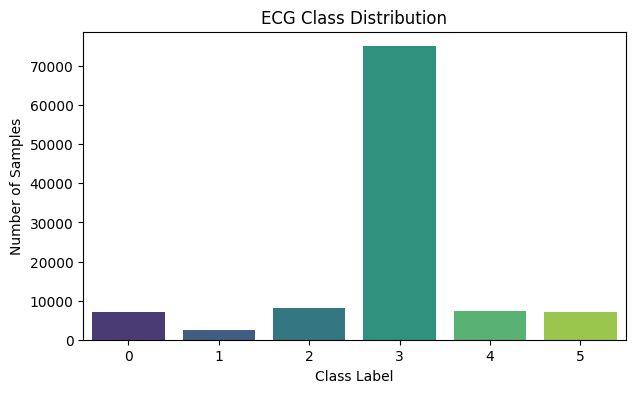

In [12]:
# CLASS DISTRIBUTION BAR PLOT
from collections import Counter

class_counts = Counter(y)
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(7,4))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("ECG Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

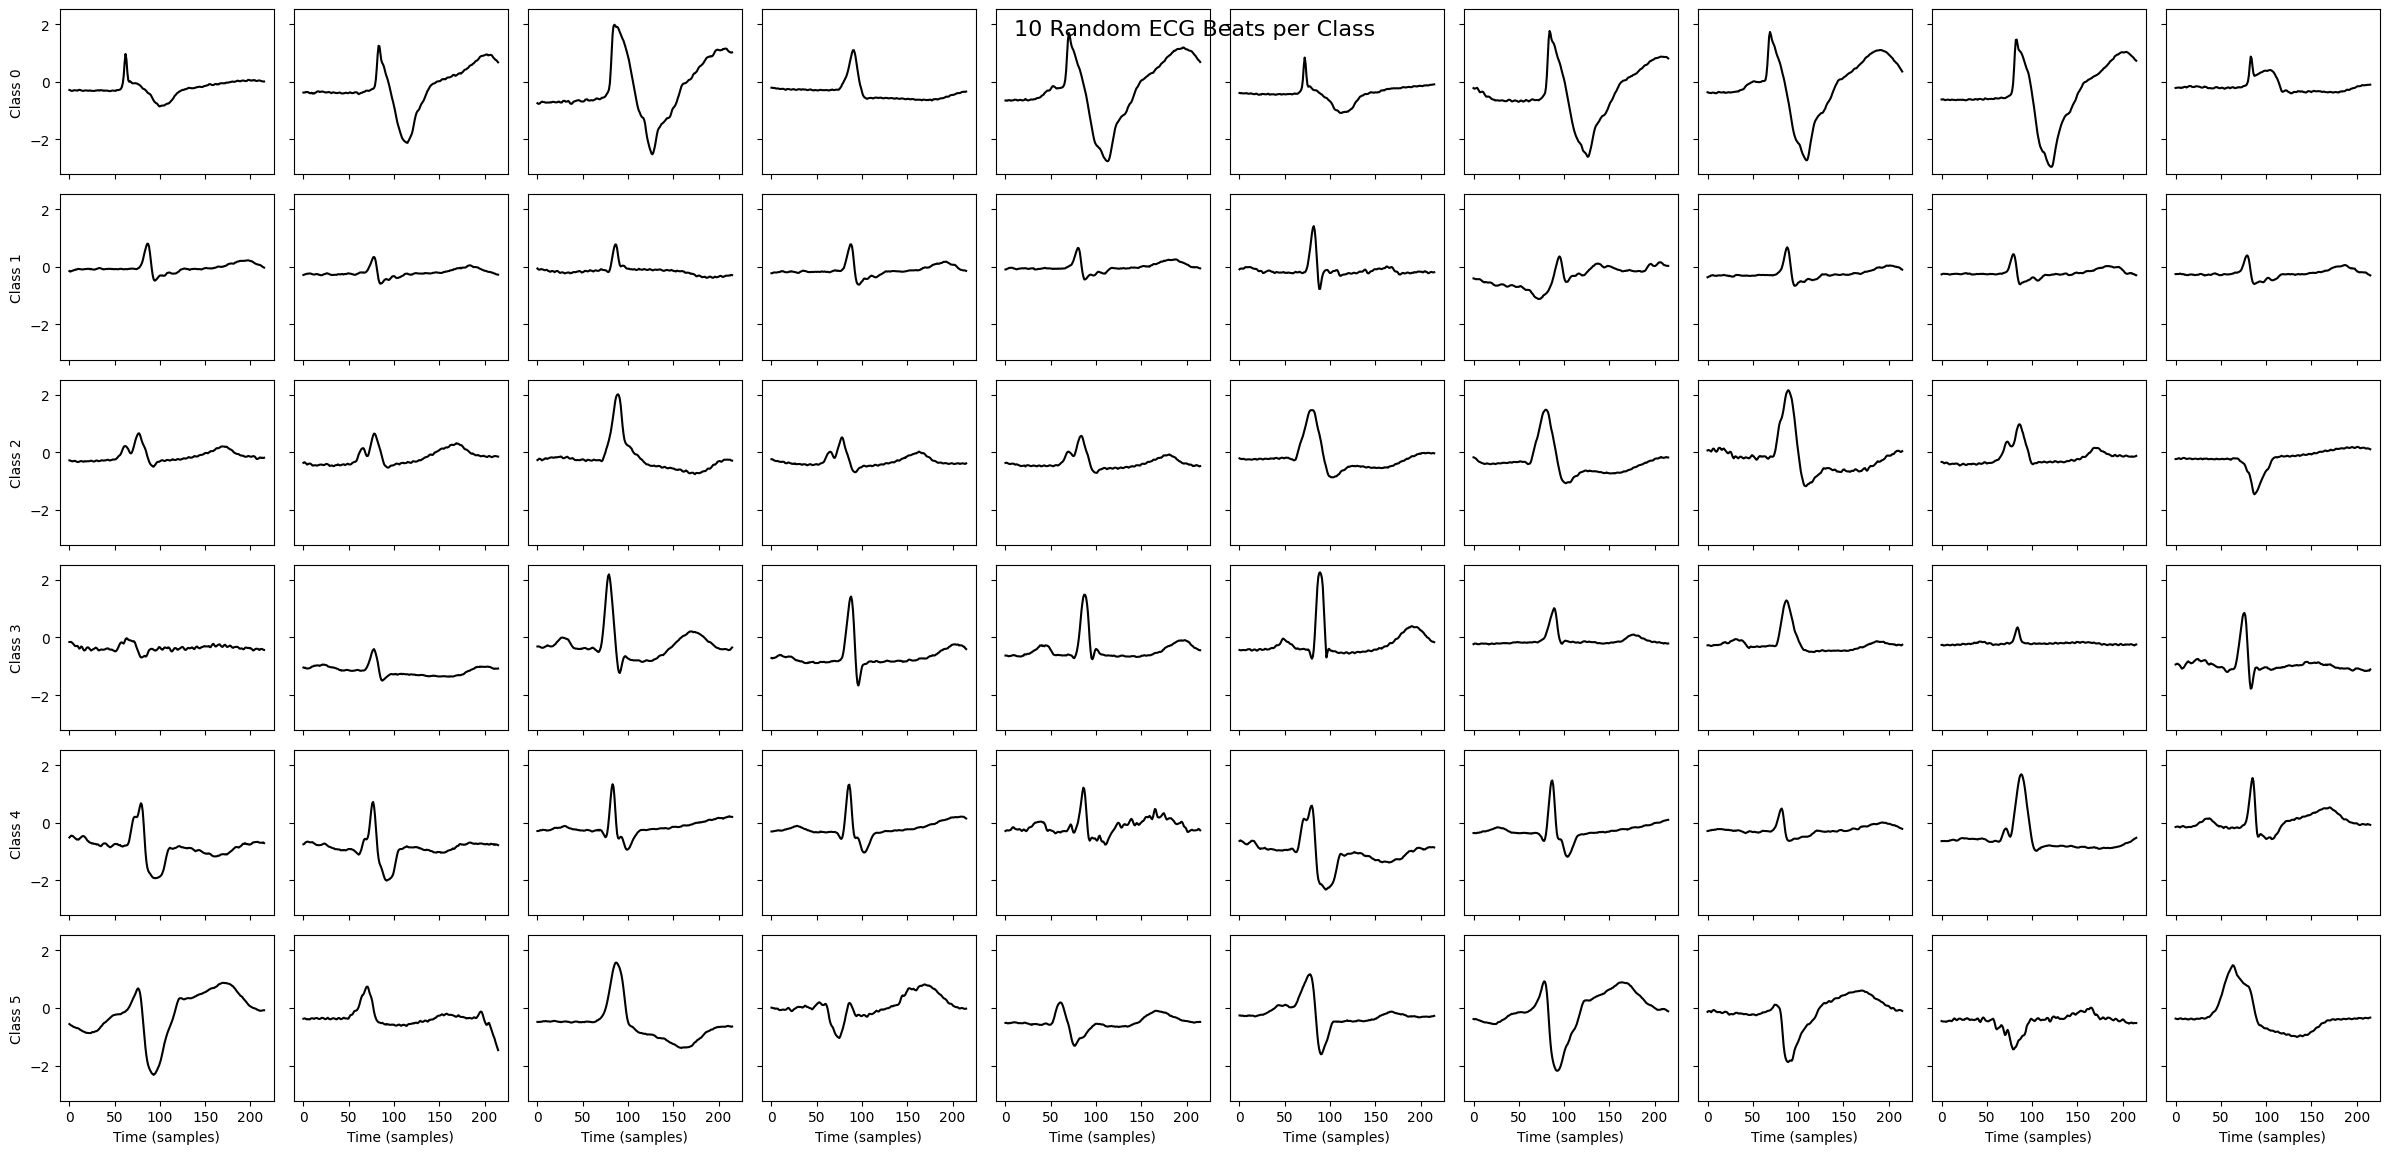

In [13]:
# RANDOM 10 BEATS PER CLASS (SUBPLOTS) WITH AXES VISIBLE
unique_classes = sorted(np.unique(y))
fig, axes = plt.subplots(len(unique_classes), 10, figsize=(24, 12), sharex=True, sharey=True)

for row, cls in enumerate(unique_classes):
    cls_indices = np.where(y == cls)[0]
    selected = np.random.choice(cls_indices, size=min(10, len(cls_indices)), replace=False)
    for col, idx in enumerate(selected):
        axes[row, col].plot(X[idx], color="black")
        
        # Y-axis label only on first column
        if col == 0:
            axes[row, col].set_ylabel(f"Class {cls}", fontsize=10)
        
        # X-axis label only on bottom row
        if row == len(unique_classes) - 1:
            axes[row, col].set_xlabel("Time (samples)")

plt.suptitle("10 Random ECG Beats per Class", y=0.95, fontsize=16)
plt.tight_layout()
plt.show()


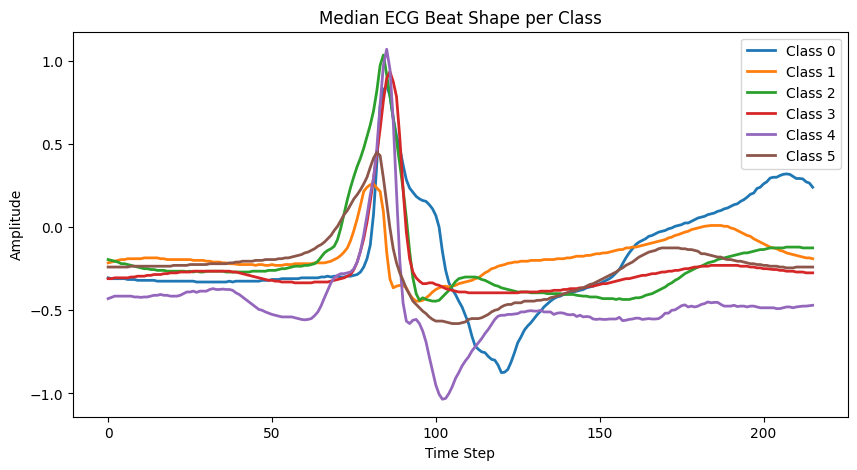

In [14]:
# MEDIAN SIGNAL PER CLASS (SHAPE OVERLAY PLOT)
plt.figure(figsize=(10, 5))

for cls in unique_classes:
    median_beat = np.median(X[y == cls], axis=0)
    plt.plot(median_beat, label=f"Class {cls}", linewidth=2)

plt.title("Median ECG Beat Shape per Class")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


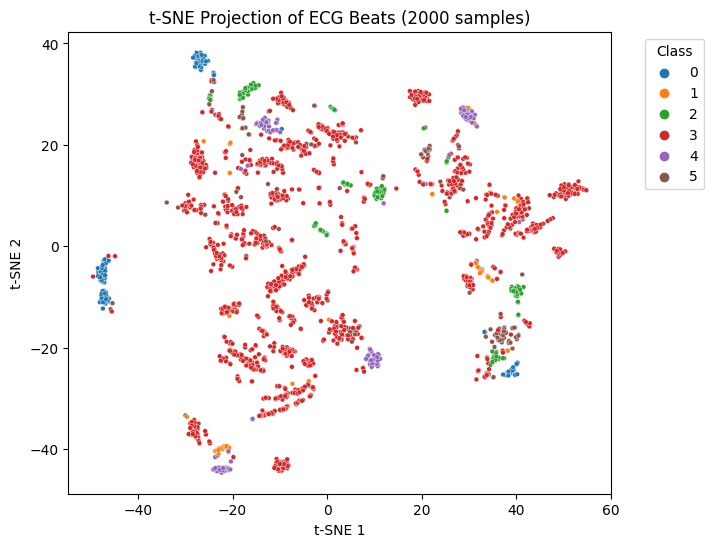

In [15]:
# t-SNE VISUALIZATION OF 2000 ECG BEATS
from sklearn.manifold import TSNE

# sample 2000 points
N = 2000
indices = np.random.choice(len(X), size=min(N, len(X)), replace=False)
X_sample = X[indices]
y_sample = y[indices]

# normalize each signal
X_norm = (X_sample - X_sample.mean(axis=1, keepdims=True)) / (X_sample.std(axis=1, keepdims=True) + 1e-8)

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_embedded = tsne.fit_transform(X_norm)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_sample, palette="tab10", s=12)
plt.title("t-SNE Projection of ECG Beats (2000 samples)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [16]:
# ======================= 9. Explainability: Captum (GradientSHAP & DeepLift) =======================
# from captum.attr import GradientShap, DeepLift

# model.eval()
# baseline = torch.zeros((1,1,CFG.SEGMENT_SAMPLES), device=CFG.DEVICE)

In [17]:
def explain_sample(idx):
    x = torch.tensor(Xva[idx][None, None, :], dtype=torch.float32, device=CFG.DEVICE)
    target = int(yva[idx])
    with torch.no_grad():
        logits = model(x)
        pred = int(torch.argmax(logits, dim=1).item())
    # GradientSHAP
    gs = GradientShap(model)
    rand_dist = torch.cat([baseline*0, baseline*0], dim=0)  # two baselines (zeros)
    attr_gs = gs.attribute(x, n_samples=50, stdevs=0.01, baselines=rand_dist, target=target)
    # DeepLift
    dl = DeepLift(model)
    attr_dl = dl.attribute(x, baselines=baseline, target=target)

    sig = x.detach().cpu().numpy().squeeze()
    ags = attr_gs.detach().cpu().numpy().squeeze()
    adl = attr_dl.detach().cpu().numpy().squeeze()

    fig, axs = plt.subplots(3,1, figsize=(10,6), sharex=True)
    axs[0].plot(sig); axs[0].set_title(f"Beat (True={CFG.ID2LABEL[target]} | Pred={CFG.ID2LABEL[pred]})")
    axs[1].plot(ags); axs[1].set_title("GradientSHAP attributions (saliency)")
    axs[2].plot(adl); axs[2].set_title("DeepLift attributions (saliency)")
    plt.tight_layout(); plt.show()

In [18]:
# Show a few explanations per paper’s preference for saliency maps over counterfactuals. :contentReference[oaicite:12]{index=12}
# for _ in range(3):
#     i = np.random.randint(0, len(Xva))
#     explain_sample(i)

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ECGBeats(Dataset):
    def __init__(self, X, y, z_norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.z_norm = z_norm
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x = self.X[i]
        if self.z_norm:
            m, s = x.mean(), x.std()
            x = (x - m) / (s + 1e-8)
        x = torch.from_numpy(x).unsqueeze(0)  # (1, 300)
        y = torch.tensor(self.y[i])
        return x, y

In [20]:
import torch.nn as nn

class BasicBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, k=7, stride=1):
        super().__init__()
        pad = k//2
        self.conv1 = nn.Conv1d(in_ch, out_ch, k, stride=stride, padding=pad, bias=False)
        self.bn1   = nn.BatchNorm1d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_ch, out_ch, k, padding=pad, bias=False)
        self.bn2   = nn.BatchNorm1d(out_ch)
        self.down  = None
        if stride != 1 or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm1d(out_ch)
            )
    def forward(self, x):
        idn = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            idn = self.down(idn)
        return self.relu(out + idn)

class ResNet1D_Lite(nn.Module):
    def __init__(self, in_ch=1, num_classes=5, width=32):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, width, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(width), nn.ReLU(inplace=True),
            nn.MaxPool1d(3, stride=2, padding=1),
        )
        self.layer1 = BasicBlock1D(width,   width*2, stride=2)
        self.layer2 = BasicBlock1D(width*2, width*4, stride=2)
        self.layer3 = BasicBlock1D(width*4, width*4, stride=1)
        self.pool   = nn.AdaptiveAvgPool1d(1)
        self.head   = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(width*4, num_classes)
        )
    def forward(self, x):     # x: (B, 1, 300)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).squeeze(-1)
        return self.head(x)


In [21]:
class BiLSTM1D(nn.Module):
    def __init__(self, in_ch=1, hidden=128, num_layers=1, num_classes=5, dropout=0.3):
        super().__init__()
        # light conv front-end to denoise & expand channels
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=7, padding=3), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2), nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=0.0)
        self.head = nn.Sequential(
            nn.LayerNorm(hidden*2),
            nn.Dropout(dropout),
            nn.Linear(hidden*2, num_classes)
        )
    def forward(self, x):          # (B, 1, 300)
        h = self.conv(x)           # (B, 64, 300)
        h = h.transpose(1, 2)      # (B, 300, 64) => time-major for LSTM
        h, _ = self.lstm(h)        # (B, 300, 2*hidden)
        h = h.mean(dim=1)          # temporal average pooling
        return self.head(h)


In [22]:
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

train_loader, val_loader, (Xva, yva) = make_loaders(X, y)

def train_and_eval_model(model, name):
    model = model.to(CFG.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    # --- metric trackers ---
    train_losses = []
    val_losses = []
    val_accs = []
    val_f1s = []

    best_acc, best_f1, best_state = 0.0, 0.0, None

    for epoch in range(1, CFG.EPOCHS+1):
        tl = train_one_epoch(model, train_loader, optimizer, criterion)
        vl, vacc, preds, probs, targs = evaluate(model, val_loader, criterion)
        curr_f1 = f1_score(targs, preds, average="macro")

        # store metrics
        train_losses.append(tl)
        val_losses.append(vl)
        val_accs.append(vacc)
        val_f1s.append(curr_f1)

        print(f"[{name}] Epoch {epoch:02d} | train_loss={tl:.4f} | val_loss={vl:.4f} | val_acc={vacc:.4f} | val_f1={curr_f1:.4f}")

        # Track best model by accuracy (or change to F1 if preferred)
        if vacc > best_acc:
            best_acc = vacc
            best_f1 = curr_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Restore best model and save
    if best_state:
        model.load_state_dict({k: v.to(CFG.DEVICE) for k, v in best_state.items()})
    torch.save(model.state_dict(), f"{name.lower()}_best.pt")
    print(f"[{name}] Best Val Acc: {best_acc:.4f} | Best Macro-F1: {best_f1:.4f} (saved {name.lower()}_best.pt)")

    # --- FINAL DETAILED EVALUATION ---
    vl, vacc, preds, probs, targs = evaluate(model, val_loader, criterion)
    print(classification_report(targs, preds, target_names=[CFG.ID2LABEL[i] for i in range(CFG.NUM_CLASSES)]))
    cm = confusion_matrix(targs, preds)
    plot_confusion_matrix(cm, [CFG.ID2LABEL[i] for i in range(CFG.NUM_CLASSES)])

    # --- METRIC PLOTS ---
    epochs = range(1, CFG.EPOCHS+1)

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{name} Loss Curve")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, val_accs, label="Val Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{name} Accuracy Curve")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, val_f1s, label="Val Macro F1")
    plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title(f"{name} F1 Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_acc, best_f1

  step 50/335  loss=1.0783
  step 100/335  loss=0.8245
  step 150/335  loss=0.6681
  step 200/335  loss=0.5456
  step 250/335  loss=0.4983
  step 300/335  loss=0.3891
[SimpleCNN] Epoch 01 | train_loss=0.6535 | val_loss=0.2961 | val_acc=0.9186 | val_f1=0.7329
  step 50/335  loss=0.3249
  step 100/335  loss=0.4530
  step 150/335  loss=0.3464
  step 200/335  loss=0.3189
  step 250/335  loss=0.3247
  step 300/335  loss=0.2483
[SimpleCNN] Epoch 02 | train_loss=0.3061 | val_loss=0.2171 | val_acc=0.9447 | val_f1=0.8612
  step 50/335  loss=0.2192
  step 100/335  loss=0.3272
  step 150/335  loss=0.2371
  step 200/335  loss=0.1688
  step 250/335  loss=0.3137
  step 300/335  loss=0.2696
[SimpleCNN] Epoch 03 | train_loss=0.2511 | val_loss=0.1940 | val_acc=0.9511 | val_f1=0.8725
  step 50/335  loss=0.2254
  step 100/335  loss=0.1562
  step 150/335  loss=0.2232
  step 200/335  loss=0.2415
  step 250/335  loss=0.2689
  step 300/335  loss=0.2380
[SimpleCNN] Epoch 04 | train_loss=0.2230 | val_loss=0.16

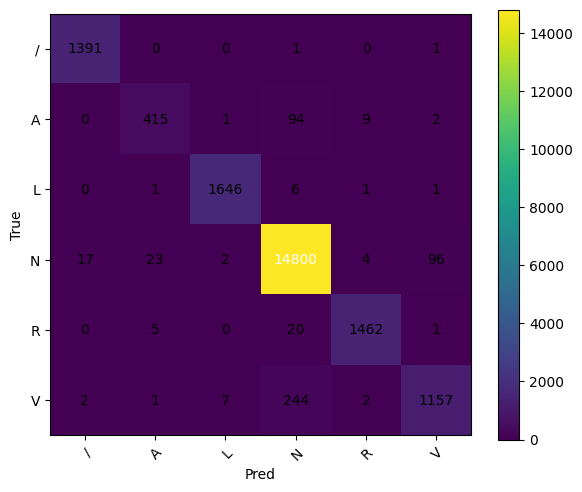

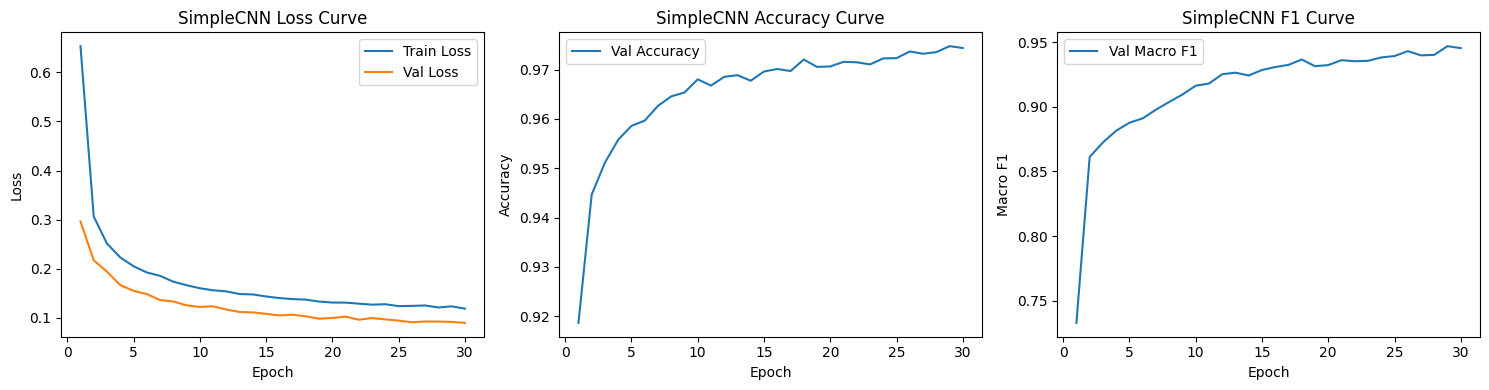

In [25]:
modelA = SimpleCNN(num_classes=CFG.NUM_CLASSES, dropout=CFG.DROPOUT).to(CFG.DEVICE)
best_acc_a,best_f1_a = train_and_eval_model(modelA,'SimpleCNN')

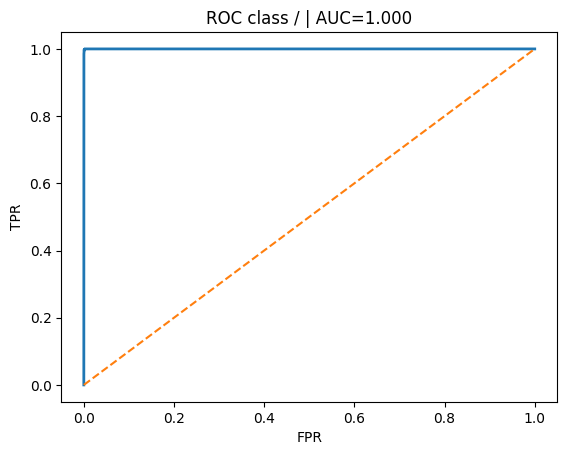

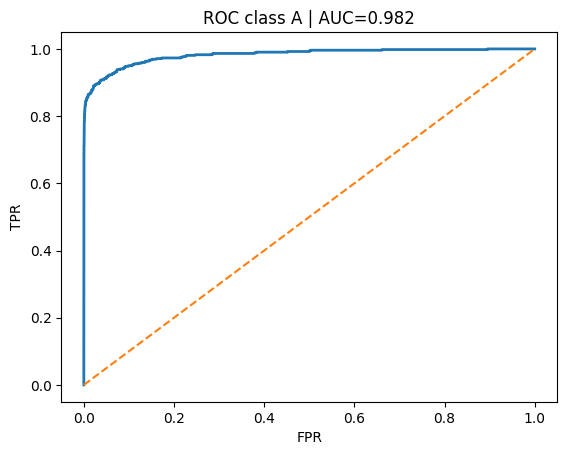

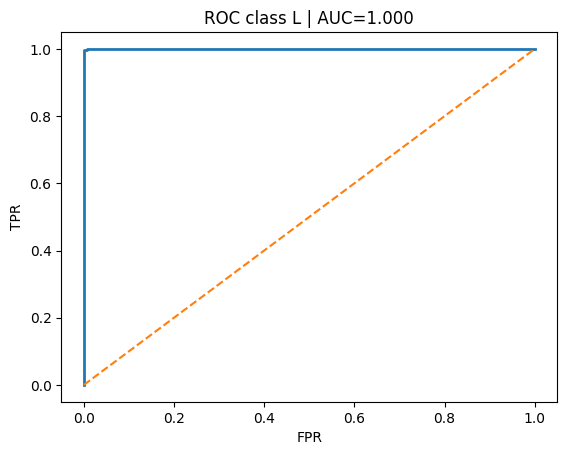

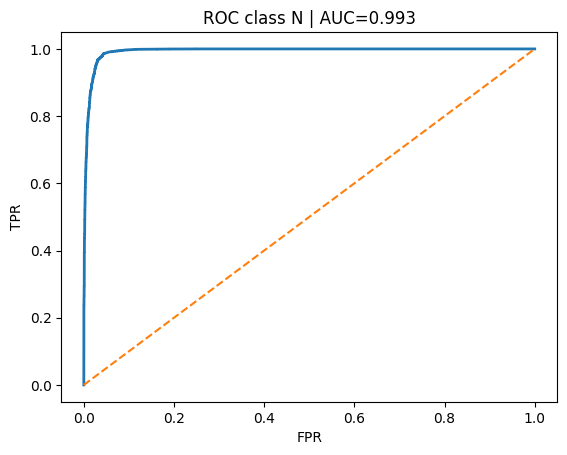

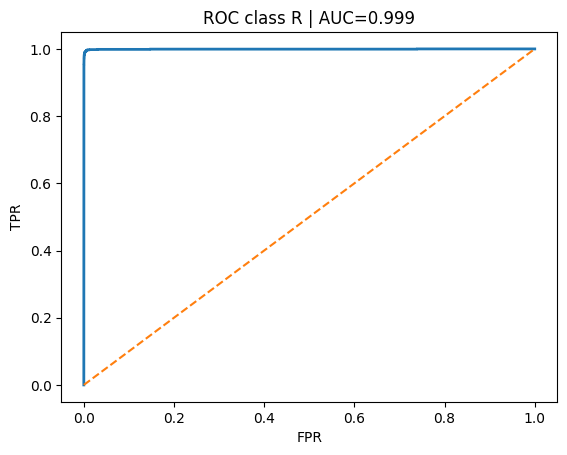

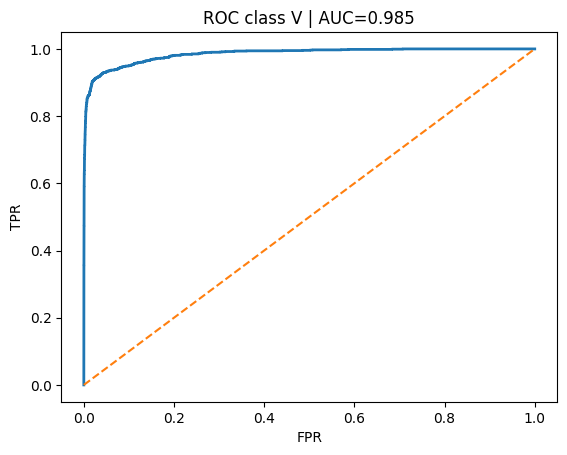

In [27]:
criterion = nn.CrossEntropyLoss()
vl, vacc, preds, probs, targs = evaluate(modelA, val_loader, criterion)
# print(classification_report(targs, preds, target_names=[CFG.ID2LABEL[i] for i in range(CFG.NUM_CLASSES)]))
# cm = confusion_matrix(targs, preds)
# plot_confusion_matrix(cm, [CFG.ID2LABEL[i] for i in range(CFG.NUM_CLASSES)])

# One-vs-rest ROC-AUC (for reference)
try:
    Y_true = label_binarize(targs, classes=list(range(CFG.NUM_CLASSES)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(CFG.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(CFG.NUM_CLASSES):
        plt.figure()
        plt.plot(fpr[i], tpr[i], lw=2)
        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC class {CFG.ID2LABEL[i]} | AUC={roc_auc[i]:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.show()
except Exception as e:
    print("ROC plotting skipped:", e)

  step 50/335  loss=0.2361
  step 100/335  loss=0.2123
  step 150/335  loss=0.1840
  step 200/335  loss=0.1887
  step 250/335  loss=0.1476
  step 300/335  loss=0.1263
[ResNet1D_Lite] Epoch 01 | train_loss=0.1846 | val_loss=0.1022 | val_acc=0.9706 | val_f1=0.9306
  step 50/335  loss=0.0625
  step 100/335  loss=0.1449
  step 150/335  loss=0.1441
  step 200/335  loss=0.1075
  step 250/335  loss=0.1075
  step 300/335  loss=0.0567
[ResNet1D_Lite] Epoch 02 | train_loss=0.1004 | val_loss=0.1011 | val_acc=0.9701 | val_f1=0.9397
  step 50/335  loss=0.0807
  step 100/335  loss=0.0545
  step 150/335  loss=0.1230
  step 200/335  loss=0.1581
  step 250/335  loss=0.0815
  step 300/335  loss=0.1141
[ResNet1D_Lite] Epoch 03 | train_loss=0.0849 | val_loss=0.1072 | val_acc=0.9710 | val_f1=0.9366
  step 50/335  loss=0.0815
  step 100/335  loss=0.0946
  step 150/335  loss=0.0697
  step 200/335  loss=0.0618
  step 250/335  loss=0.0503
  step 300/335  loss=0.0504
[ResNet1D_Lite] Epoch 04 | train_loss=0.0779

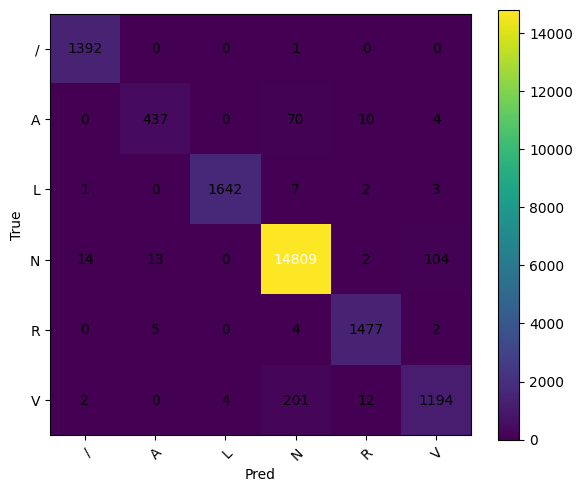

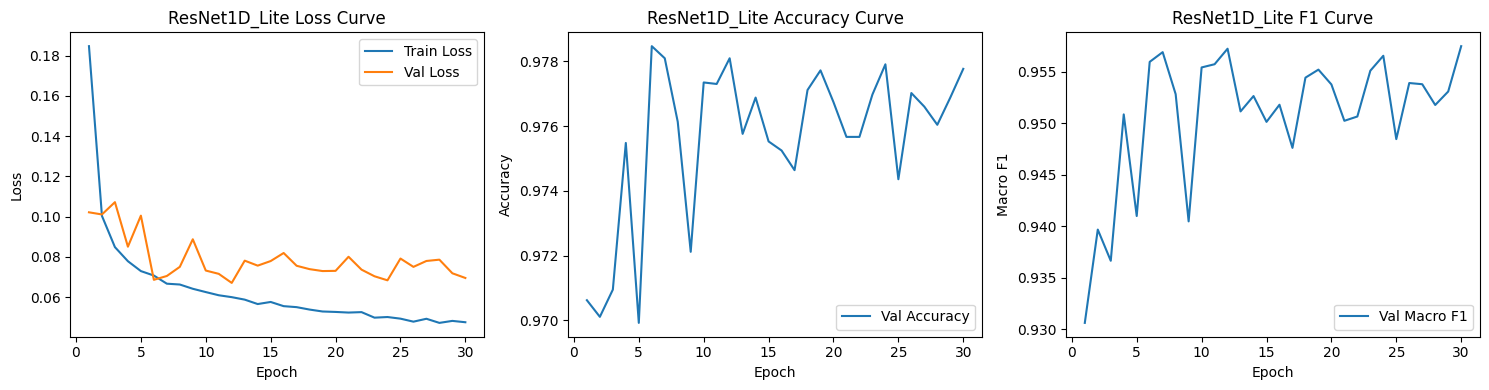

In [29]:
# Model B: ResNet1D-Lite
modelB = ResNet1D_Lite(in_ch=1, num_classes=CFG.NUM_CLASSES)
best_acc_b,best_f1_b = train_and_eval_model(modelB, "ResNet1D_Lite")

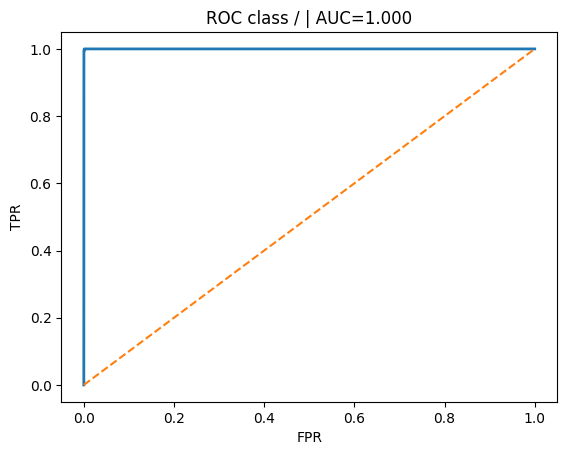

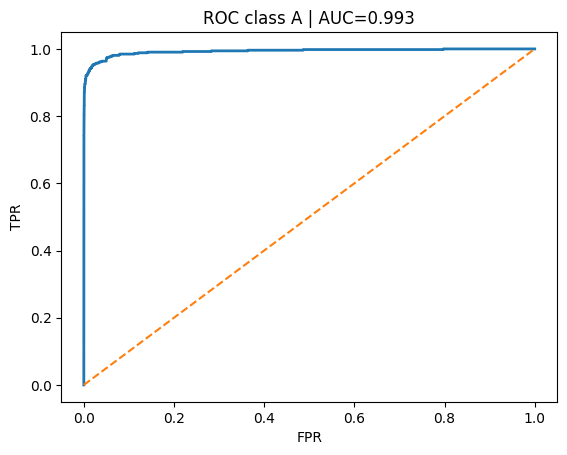

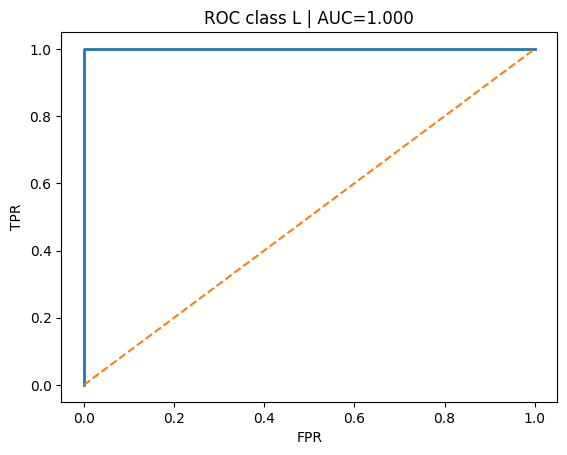

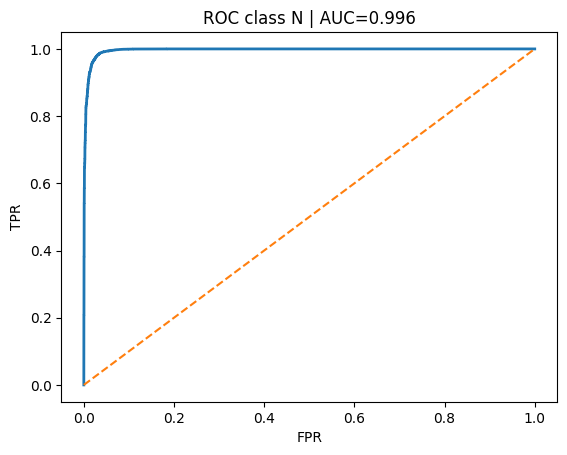

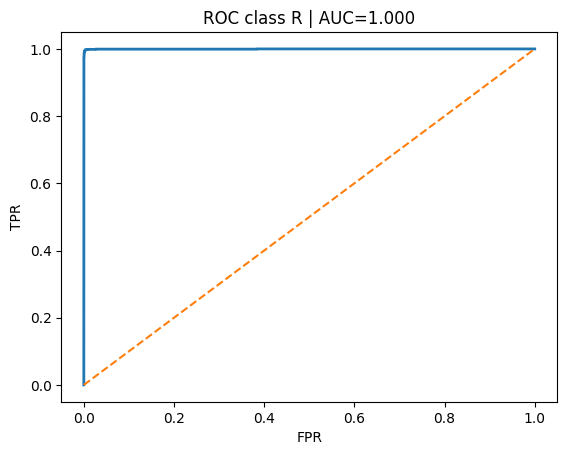

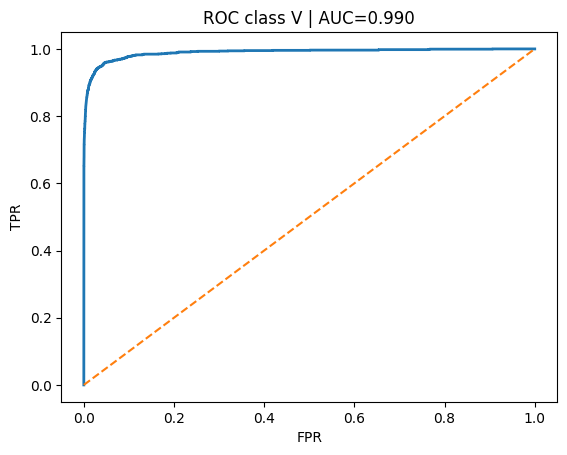

In [30]:
vl, vacc, preds, probs, targs = evaluate(modelB, val_loader, criterion)


# One-vs-rest ROC-AUC (for reference)
try:
    Y_true = label_binarize(targs, classes=list(range(CFG.NUM_CLASSES)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(CFG.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(CFG.NUM_CLASSES):
        plt.figure()
        plt.plot(fpr[i], tpr[i], lw=2)
        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC class {CFG.ID2LABEL[i]} | AUC={roc_auc[i]:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.show()
except Exception as e:
    print("ROC plotting skipped:", e)

  step 50/335  loss=0.9041
  step 100/335  loss=0.8790
  step 150/335  loss=0.6079
  step 200/335  loss=0.6901
  step 250/335  loss=0.7095
  step 300/335  loss=0.3919
[BiLSTM1D] Epoch 01 | train_loss=0.7128 | val_loss=0.4057 | val_acc=0.8747 | val_f1=0.6773
  step 50/335  loss=0.3739
  step 100/335  loss=0.3112
  step 150/335  loss=0.2769
  step 200/335  loss=0.2281
  step 250/335  loss=0.2885
  step 300/335  loss=0.3480
[BiLSTM1D] Epoch 02 | train_loss=0.3252 | val_loss=0.2131 | val_acc=0.9457 | val_f1=0.8645
  step 50/335  loss=0.2076
  step 100/335  loss=0.2563
  step 150/335  loss=0.2882
  step 200/335  loss=0.2178
  step 250/335  loss=0.2493
  step 300/335  loss=0.2039
[BiLSTM1D] Epoch 03 | train_loss=0.2092 | val_loss=0.1893 | val_acc=0.9518 | val_f1=0.8727
  step 50/335  loss=0.1682
  step 100/335  loss=0.2587
  step 150/335  loss=0.1486
  step 200/335  loss=0.1146
  step 250/335  loss=0.1727
  step 300/335  loss=0.1886
[BiLSTM1D] Epoch 04 | train_loss=0.1796 | val_loss=0.1678 |

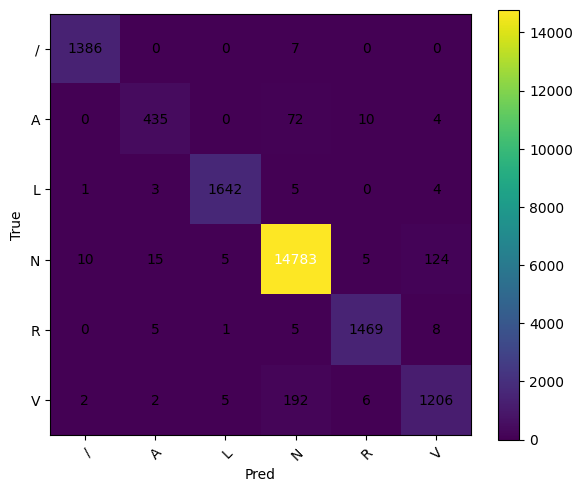

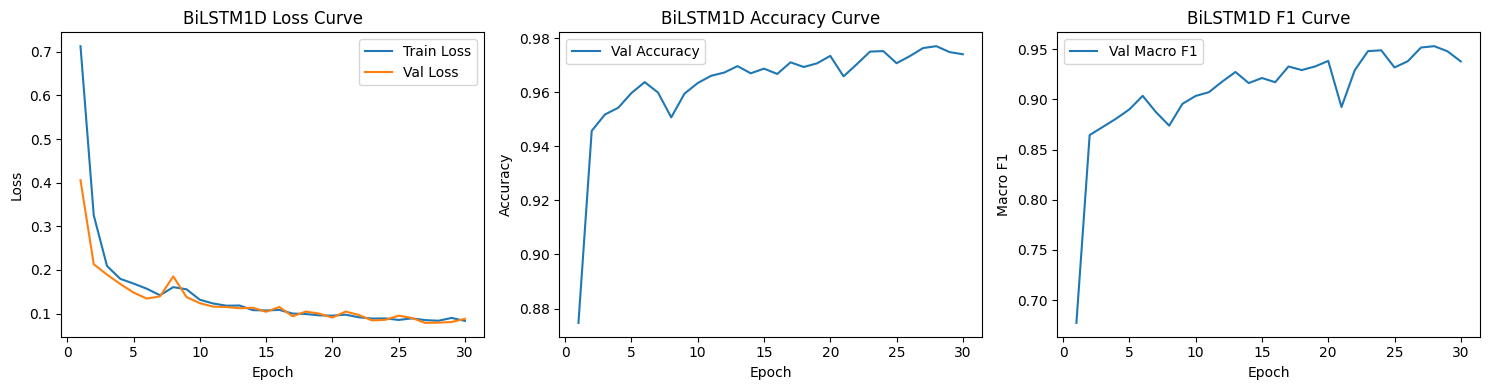

In [31]:
# Model C: BiLSTM
modelC = BiLSTM1D(in_ch=1, hidden=128, num_layers=1, num_classes=CFG.NUM_CLASSES, dropout=CFG.DROPOUT)
best_acc_c,best_f1_c = train_and_eval_model(modelC, "BiLSTM1D")

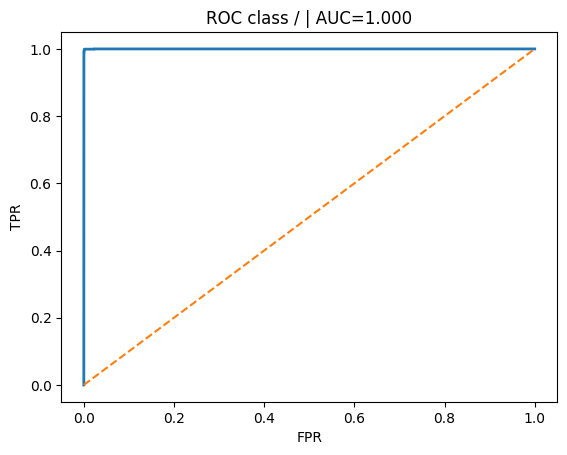

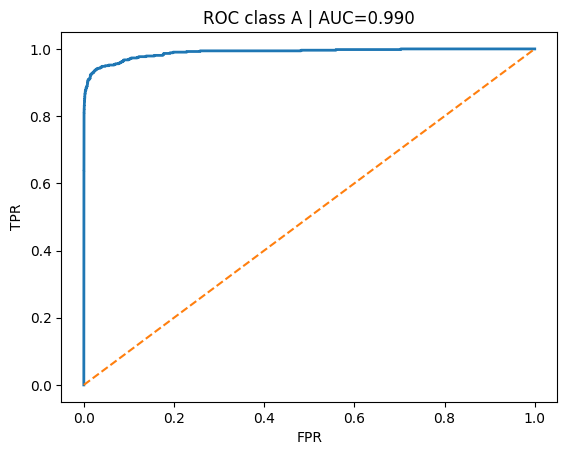

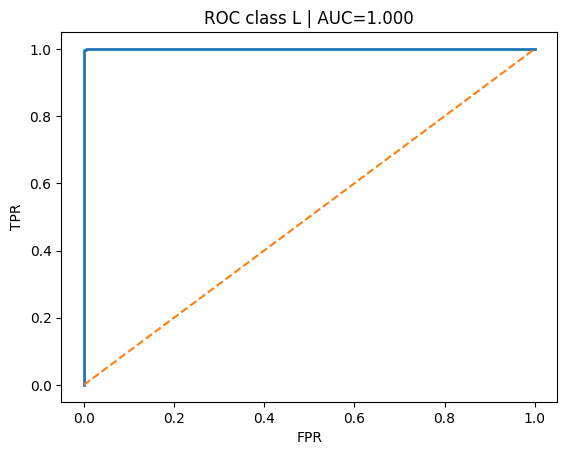

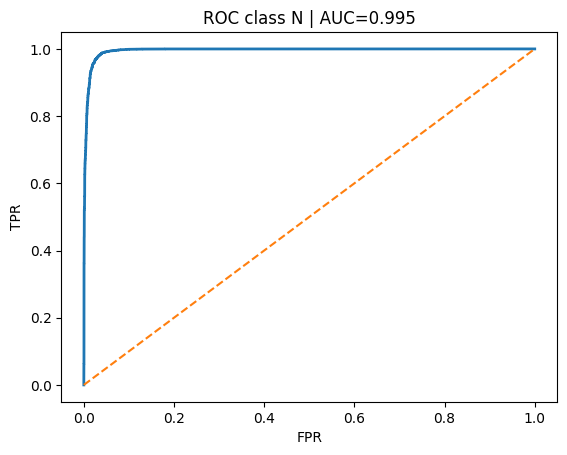

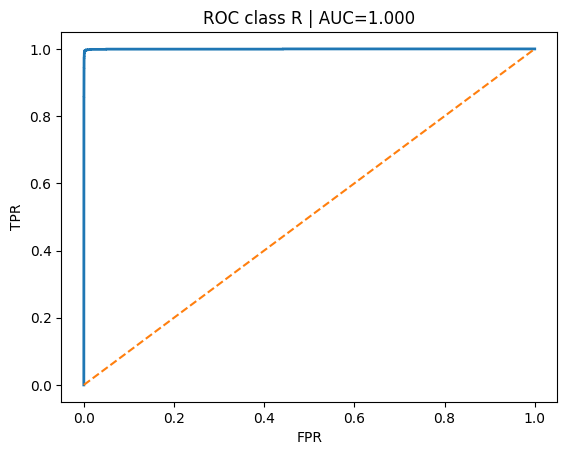

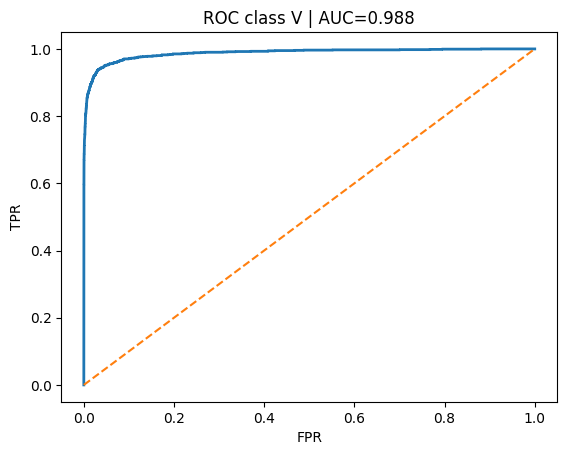

In [32]:
vl, vacc, preds, probs, targs = evaluate(modelC, val_loader, criterion)

# One-vs-rest ROC-AUC (for reference)
try:
    Y_true = label_binarize(targs, classes=list(range(CFG.NUM_CLASSES)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(CFG.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(CFG.NUM_CLASSES):
        plt.figure()
        plt.plot(fpr[i], tpr[i], lw=2)
        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC class {CFG.ID2LABEL[i]} | AUC={roc_auc[i]:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.show()
except Exception as e:
    print("ROC plotting skipped:", e)

In [34]:
rows = [
    ("SimpleCNN", best_acc_a, best_f1_a),
    ("ResNet1D_Lite", best_acc_b, best_f1_b),
    ("BiLSTM1D", best_acc_c, best_f1_c),
]

df = pd.DataFrame(rows, columns=["Model", "Val Accuracy", "Macro-F1"])
print(df)

           Model  Val Accuracy  Macro-F1
0      SimpleCNN      0.974734  0.946887
1  ResNet1D_Lite      0.978470  0.955940
2       BiLSTM1D      0.977069  0.953094
